<a href="https://colab.research.google.com/github/Roudranil/aml-assignment-1/blob/main/src/aml_assignmnent_1_sign_language_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
! ln -s /content/drive/MyDrive/aml-assignments/assignment-1/ assignment-1

In [3]:
! pip install torchmetrics torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.1 MB/s eta 0:00:00


# Imports

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary
import torchmetrics
import torchvision
from torchvision import datasets, transforms, utils

In [5]:
from tqdm import tqdm
import os
import gc

# Creating the dataset class

In [6]:
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.835398144


In [7]:
!nvidia-smi

Sat Oct 14 12:52:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=8e20d25ae4227ad5a4f45bb8e363f4addffa09d30ee7590b537551acfebd9db7
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 12.2 GB  | Proc size: 562.4 MB
GPU RAM Free: 15098MB | Used: 3MB | Util   0% | Total 15360MB


In [24]:
# constants

BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class SignLanguageMnist(Dataset):
    def __init__(self, img_file, transform=None, device="cpu"):
        self.labels_map = {
            idx: chr(letter) for idx, letter in zip(range(26), range(65, 91))
        }
        self.imgs = pd.read_csv(img_file)
        self.labels = torch.tensor(self.imgs["label"], device=device)
        self.imgs.drop(columns=["label"], inplace=True)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = torch.tensor(self.imgs.loc[index, :]).view((1, 28, 28)) / 255
        if self.transform:
            img = self.transform(img)
        img = img.to(self.device)
        return img, self.labels[index]

# DNN

In [19]:
class DeepNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 26),
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        predictions = self.logsoftmax(logits)
        return predictions


dnn = DeepNN().to(DEVICE)
print(summary(dnn, (BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
DeepNN                                   [128, 26]                 --
├─Flatten: 1-1                           [128, 784]                --
├─Sequential: 1-2                        [128, 26]                 --
│    └─Linear: 2-1                       [128, 200]                157,000
│    └─ReLU: 2-2                         [128, 200]                --
│    └─Linear: 2-3                       [128, 100]                20,100
│    └─ReLU: 2-4                         [128, 100]                --
│    └─Linear: 2-5                       [128, 60]                 6,060
│    └─ReLU: 2-6                         [128, 60]                 --
│    └─Linear: 2-7                       [128, 26]                 1,586
├─LogSoftmax: 1-3                        [128, 26]                 --
Total params: 184,746
Trainable params: 184,746
Non-trainable params: 0
Total mult-adds (M): 23.65
Input size (MB): 0.40
Forward/backward pa

# CNN

In [36]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6, padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6, padding=0)
        self.fc1 = nn.Linear(128, 200)
        self.fc2 = nn.Linear(200, 26)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        logits = self.fc2(x)
        predictions = self.logsoftmax(logits)
        return predictions


cnn = CNN().to(DEVICE)
print(summary(cnn, (BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [128, 26]                 --
├─Conv2d: 1-1                            [128, 12, 26, 26]         120
├─ReLU: 1-2                              [128, 12, 26, 26]         --
├─Conv2d: 1-3                            [128, 24, 21, 21]         10,392
├─ReLU: 1-4                              [128, 24, 21, 21]         --
├─MaxPool2d: 1-5                         [128, 24, 10, 10]         --
├─Conv2d: 1-6                            [128, 32, 5, 5]           27,680
├─ReLU: 1-7                              [128, 32, 5, 5]           --
├─MaxPool2d: 1-8                         [128, 32, 2, 2]           --
├─Flatten: 1-9                           [128, 128]                --
├─Linear: 1-10                           [128, 200]                25,800
├─Linear: 1-11                           [128, 26]                 5,226
├─LogSoftmax: 1-12                       [128, 26]                 --

In [83]:
class CNNDropout(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6, padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6, padding=0)
        self.fc1 = nn.Linear(128, 200)
        self.fc2 = nn.Linear(200, 26)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        predictions = self.logsoftmax(logits)
        return predictions


cnn = CNNDropout().to(DEVICE)
print(summary(cnn, (BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNNDropout                               [128, 26]                 --
├─Conv2d: 1-1                            [128, 12, 26, 26]         120
├─ReLU: 1-2                              [128, 12, 26, 26]         --
├─Conv2d: 1-3                            [128, 24, 21, 21]         10,392
├─ReLU: 1-4                              [128, 24, 21, 21]         --
├─MaxPool2d: 1-5                         [128, 24, 10, 10]         --
├─Conv2d: 1-6                            [128, 32, 5, 5]           27,680
├─ReLU: 1-7                              [128, 32, 5, 5]           --
├─MaxPool2d: 1-8                         [128, 32, 2, 2]           --
├─Flatten: 1-9                           [128, 128]                --
├─Linear: 1-10                           [128, 200]                25,800
├─ReLU: 1-11                             [128, 200]                --
├─Dropout: 1-12                          [128, 200]                --
├─

# Training Loop

In [37]:
def train_one_epoch(model, train, loss_fn, optimizer, metric, device, epoch):
    loop = tqdm(train)
    for inputs, targets in loop:  # iterates over all the batches
        loop.set_description_str(f"Epoch = {epoch}")
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()
        loop.set_postfix_str(
            f"Loss = {loss.item(): .3f}"
        )



def train(model, train, test, loss_fn, optimizer, metric, device, epochs, name):
    for i in range(epochs):  # iterates over the epochs
        model.train(True)
        train_one_epoch(
            model, train, loss_fn, optimizer, metric, device, i + 1
        )
        loss, acc = test_one_epoch(
            model, test, loss_fn, metric, device
        )
        print(f"Test loss = {loss: .3f} | Test cccuracy = {100. * acc: .2f}")
    # return training_loss_per_epoch, training_accuracy_per_epoch, test_loss_per_epoch, test_accuracy_per_epoch
    return


@torch.no_grad()
def test_one_epoch(model, test, loss_fn, metric, device):
    model.train(False)
    running_loss, running_accuracy = [], []
    for inputs, targets in test:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        accuracy = metric(predictions, targets)
        running_loss.append(loss.to('cpu').item())
        running_accuracy.append(accuracy.to('cpu'))

    return np.mean(running_loss), np.mean(running_accuracy)



In [26]:
def train_network(model, train_dataloader, test_dataloader, epochs, name):
    loss_fn = nn.NLLLoss().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=26, top_k=1).to(DEVICE)
    train(model, train_dataloader, test_dataloader, loss_fn, optimizer, metric, DEVICE, epochs, name)

In [78]:
def visualise_individual_predictions(img, pred_label, real_label, predicted_probabilities):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].axis("off")
    axs[1].bar(np.arange(26), predicted_probabilities)
    axs[1].set_xticks(np.arange(26))
    axs[1].set_xticklabels(np.arange(26))
    axs[1].set_title('Prediction Probability')
    axs[1].set_ylim(0, 1.1)
    axs[0].set_title(f"predicted = {pred_label} | real = {real_label}")
    plt.tight_layout()

def visualise_performance(model):
    model.to(DEVICE)
    image_batch, label_batch = next(iter(test_dataloader))
    with torch.no_grad():
        log_predicted_probabilities_batch = model(image_batch)
        for i in range(10):
            img = image_batch[i].to("cpu").squeeze()
            real_label = label_batch[i].to("cpu").item()
            log_predicted_probabilities = log_predicted_probabilities_batch[i].to("cpu")
            predicted_probabilities = torch.exp(log_predicted_probabilities).numpy()
            predicted_label = np.argmax(predicted_probabilities)
            visualise_individual_predictions(img, predicted_label, real_label, predicted_probabilities)

In [20]:
train_data = SignLanguageMnist(
    "assignment-1/data/sign-language-mnist/sign_mnist_train.csv", device=DEVICE
)
test_data = SignLanguageMnist(
    "assignment-1/data/sign-language-mnist/sign_mnist_test.csv", device=DEVICE
)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [79]:
model = DeepNN().to(DEVICE)
train_network(model, train_dataloader, test_dataloader, 30, "dnn")

Epoch = 1: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  2.244]


Test loss =  2.253 | Test cccuracy =  24.92


Epoch = 2: 100%|██████████| 215/215 [01:00<00:00,  3.56it/s, Loss =  1.630]


Test loss =  1.943 | Test cccuracy =  37.35


Epoch = 3: 100%|██████████| 215/215 [01:00<00:00,  3.58it/s, Loss =  1.479]


Test loss =  1.671 | Test cccuracy =  47.45


Epoch = 4: 100%|██████████| 215/215 [01:02<00:00,  3.45it/s, Loss =  1.147]


Test loss =  1.540 | Test cccuracy =  49.44


Epoch = 5: 100%|██████████| 215/215 [01:00<00:00,  3.57it/s, Loss =  1.101]


Test loss =  1.428 | Test cccuracy =  54.44


Epoch = 6: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.800]


Test loss =  1.334 | Test cccuracy =  58.14


Epoch = 7: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  0.907]


Test loss =  1.248 | Test cccuracy =  62.50


Epoch = 8: 100%|██████████| 215/215 [01:00<00:00,  3.52it/s, Loss =  0.589]


Test loss =  1.232 | Test cccuracy =  61.87


Epoch = 9: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  0.524]


Test loss =  1.218 | Test cccuracy =  62.12


Epoch = 10: 100%|██████████| 215/215 [01:00<00:00,  3.55it/s, Loss =  0.369]


Test loss =  1.268 | Test cccuracy =  63.45


Epoch = 11: 100%|██████████| 215/215 [01:00<00:00,  3.57it/s, Loss =  0.467]


Test loss =  1.254 | Test cccuracy =  63.31


Epoch = 12: 100%|██████████| 215/215 [01:01<00:00,  3.49it/s, Loss =  0.333]


Test loss =  1.242 | Test cccuracy =  66.75


Epoch = 13: 100%|██████████| 215/215 [01:00<00:00,  3.56it/s, Loss =  0.245]


Test loss =  1.356 | Test cccuracy =  65.61


Epoch = 14: 100%|██████████| 215/215 [01:00<00:00,  3.56it/s, Loss =  0.185]


Test loss =  1.376 | Test cccuracy =  64.72


Epoch = 15: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.171]


KeyboardInterrupt: ignored

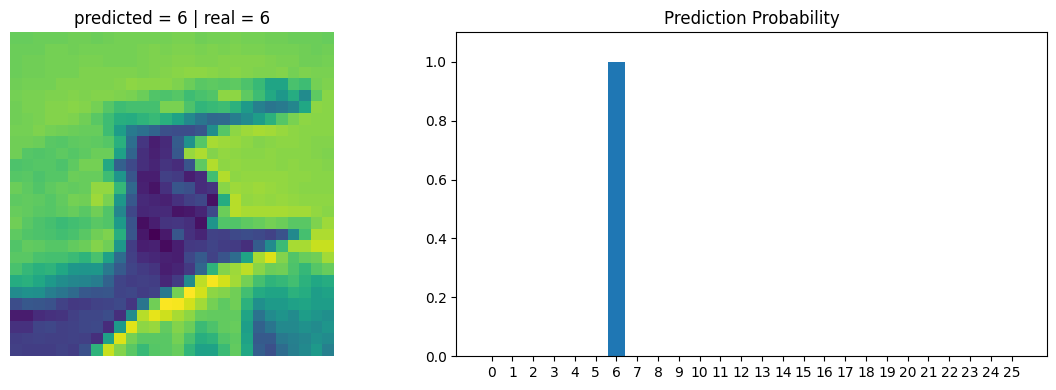

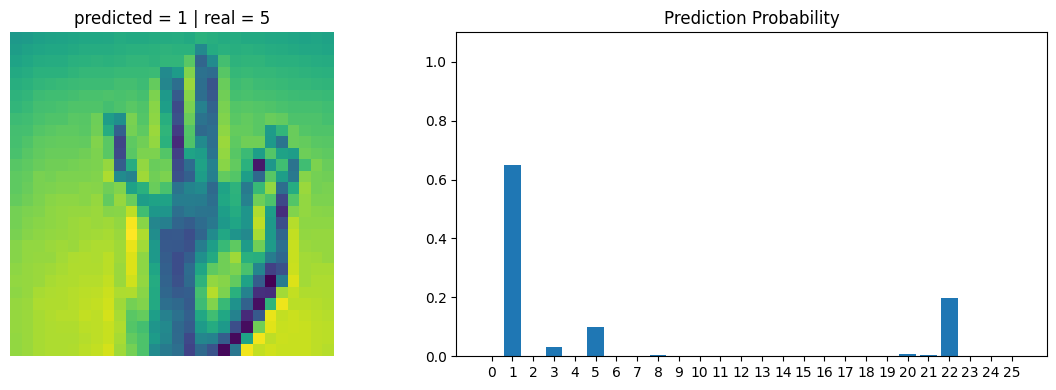

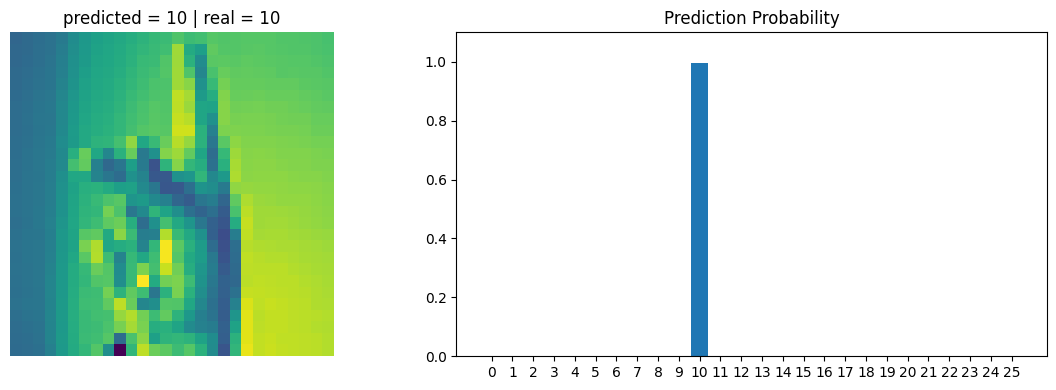

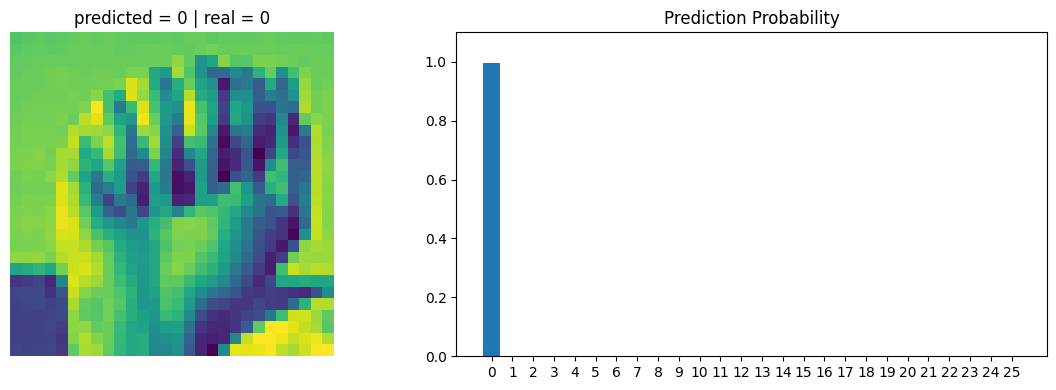

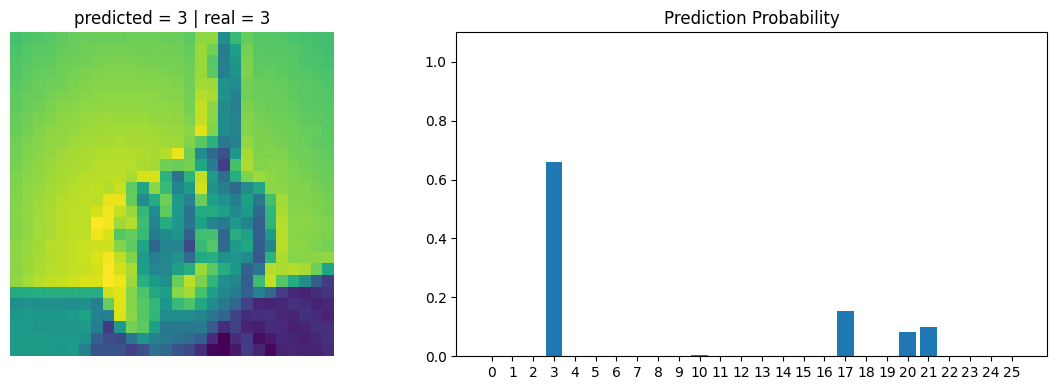

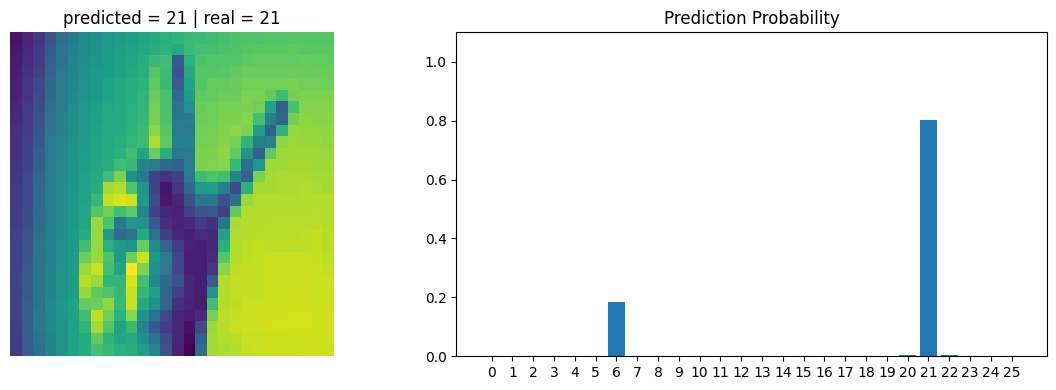

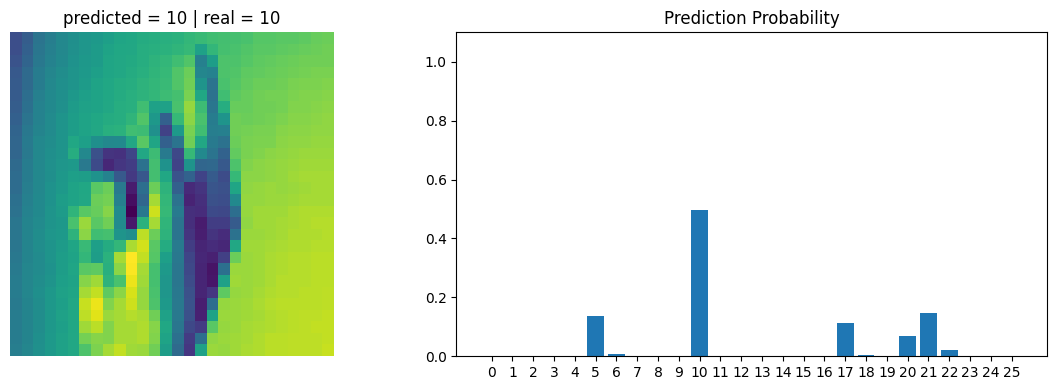

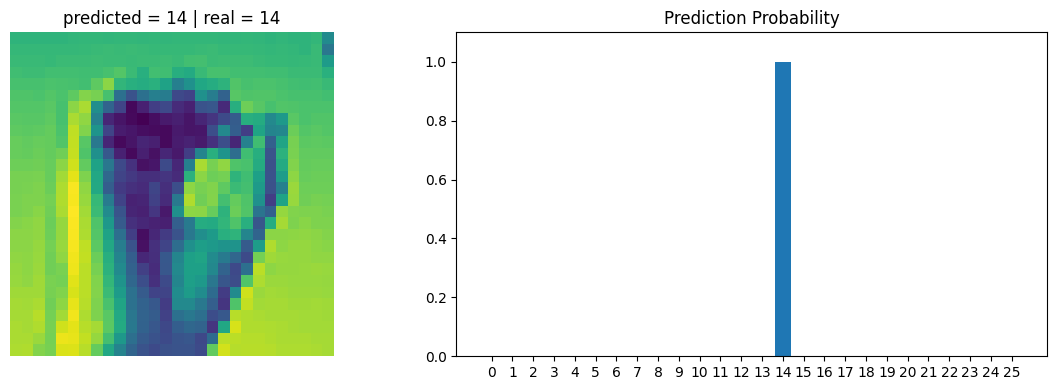

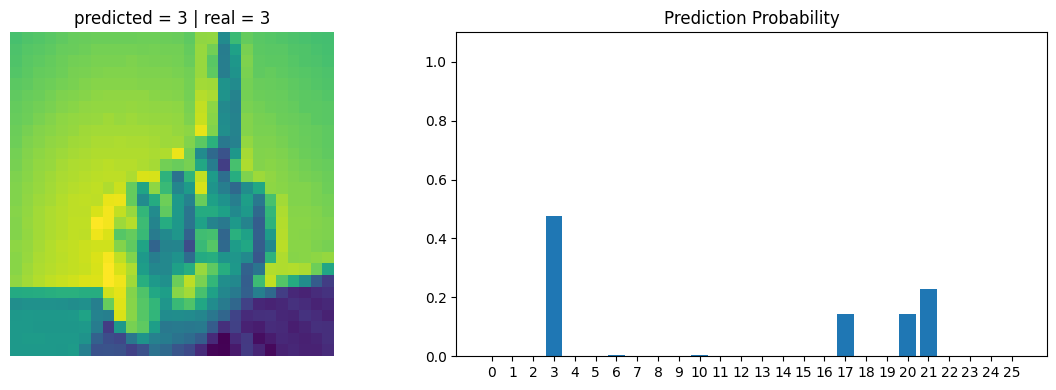

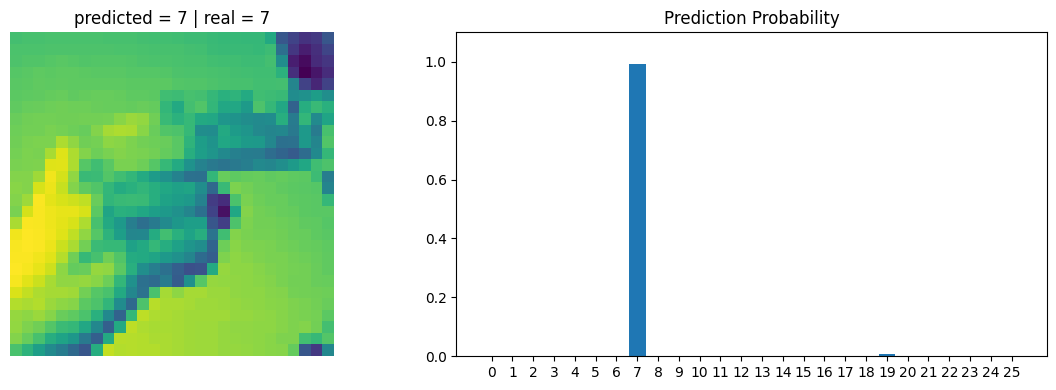

In [80]:
visualise_performance(model)

In [81]:
model = CNN().to(DEVICE)
train_network(model, train_dataloader, test_dataloader, 15, "cnn")

Epoch = 1: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  1.333]


Test loss =  1.485 | Test cccuracy =  50.48


Epoch = 2: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.743]


Test loss =  0.979 | Test cccuracy =  69.45


Epoch = 3: 100%|██████████| 215/215 [01:02<00:00,  3.45it/s, Loss =  0.564]


Test loss =  0.862 | Test cccuracy =  73.56


Epoch = 4: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.305]


Test loss =  0.786 | Test cccuracy =  76.12


Epoch = 5: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  0.274]


Test loss =  0.816 | Test cccuracy =  77.41


Epoch = 6: 100%|██████████| 215/215 [01:03<00:00,  3.41it/s, Loss =  0.252]


Test loss =  0.858 | Test cccuracy =  76.91


Epoch = 7: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.071]


Test loss =  0.876 | Test cccuracy =  78.41


Epoch = 8: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.123]


Test loss =  1.144 | Test cccuracy =  78.08


Epoch = 9: 100%|██████████| 215/215 [01:02<00:00,  3.42it/s, Loss =  0.065]


Test loss =  1.179 | Test cccuracy =  78.87


Epoch = 10: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.084]


Test loss =  1.200 | Test cccuracy =  77.55


Epoch = 11: 100%|██████████| 215/215 [01:02<00:00,  3.42it/s, Loss =  0.034]


Test loss =  1.297 | Test cccuracy =  79.95


Epoch = 12: 100%|██████████| 215/215 [01:01<00:00,  3.50it/s, Loss =  0.012]


Test loss =  1.277 | Test cccuracy =  79.95


Epoch = 13: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  0.021]


Test loss =  1.441 | Test cccuracy =  79.95


Epoch = 14: 100%|██████████| 215/215 [01:03<00:00,  3.37it/s, Loss =  0.029]


Test loss =  1.344 | Test cccuracy =  80.73


Epoch = 15: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.024]


Test loss =  1.363 | Test cccuracy =  79.48


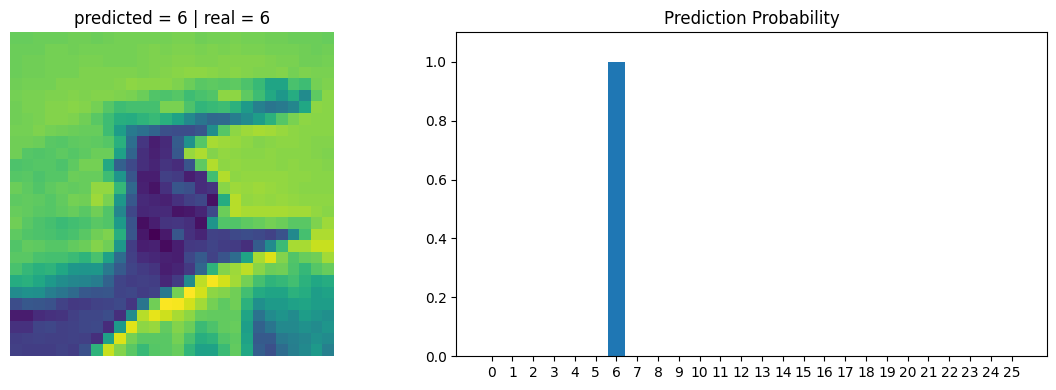

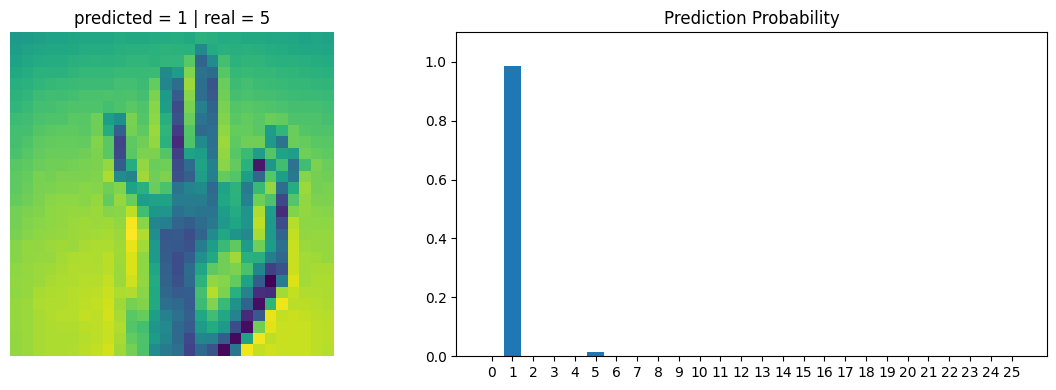

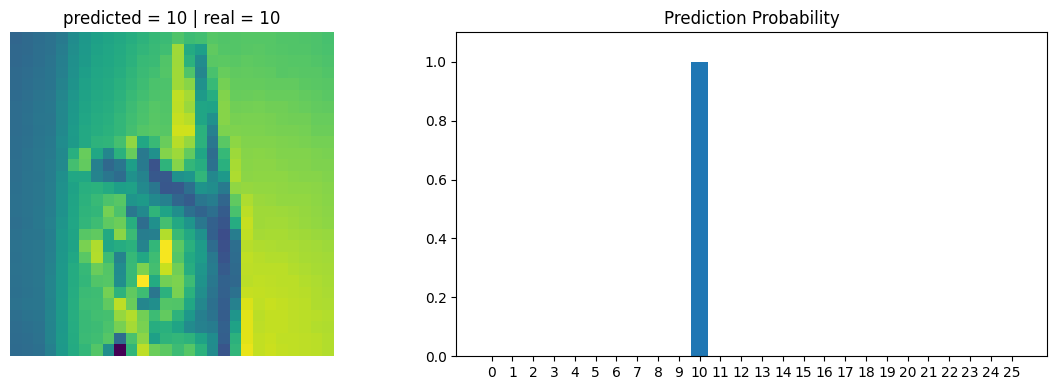

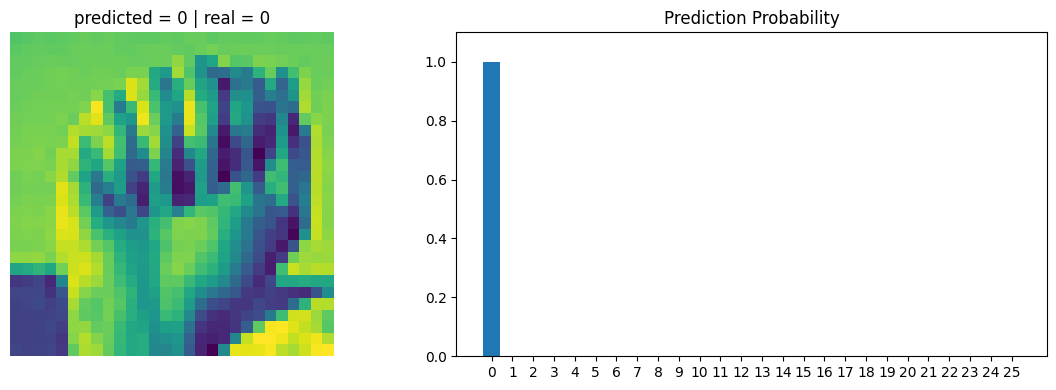

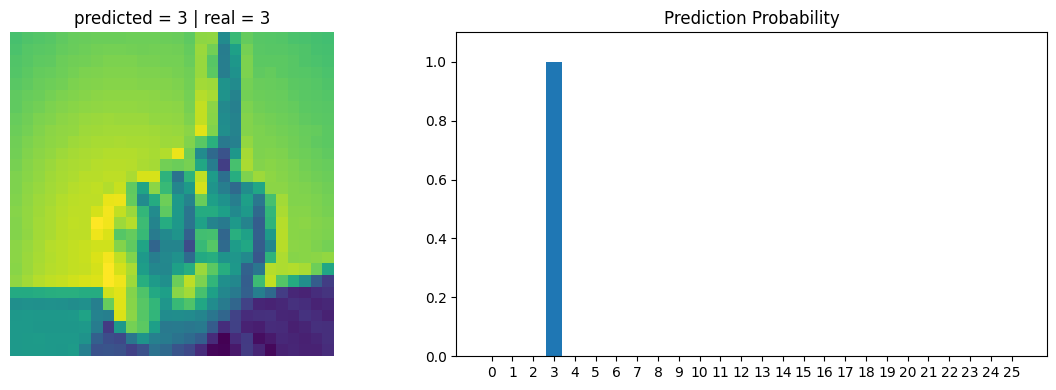

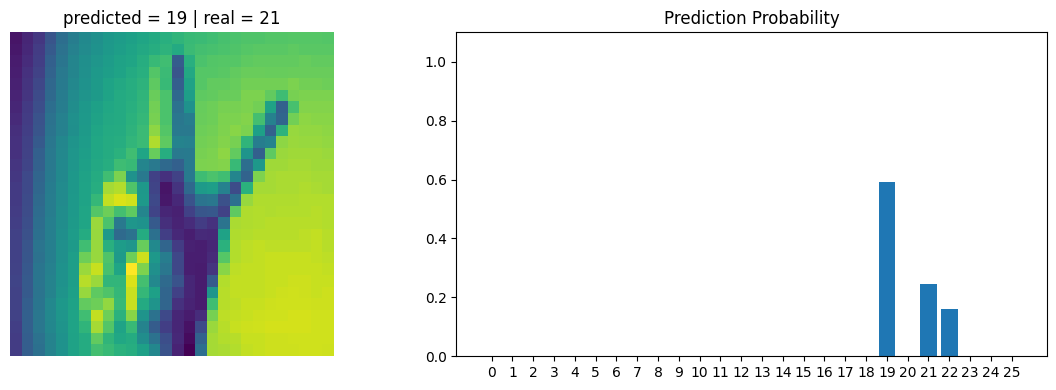

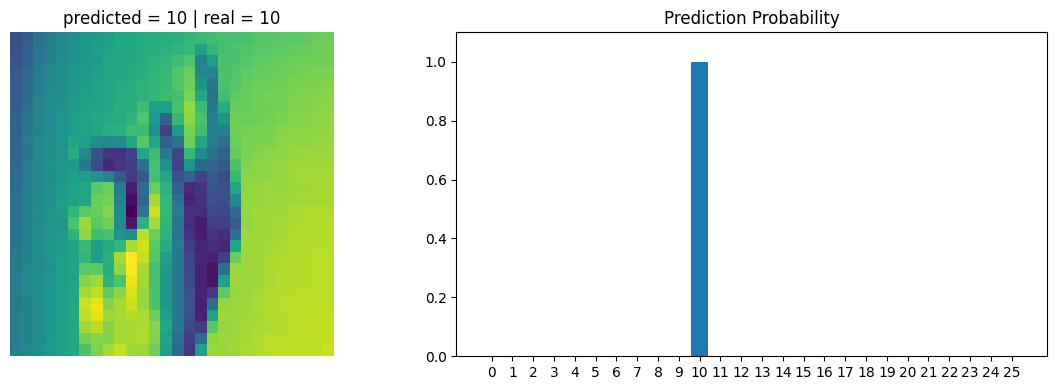

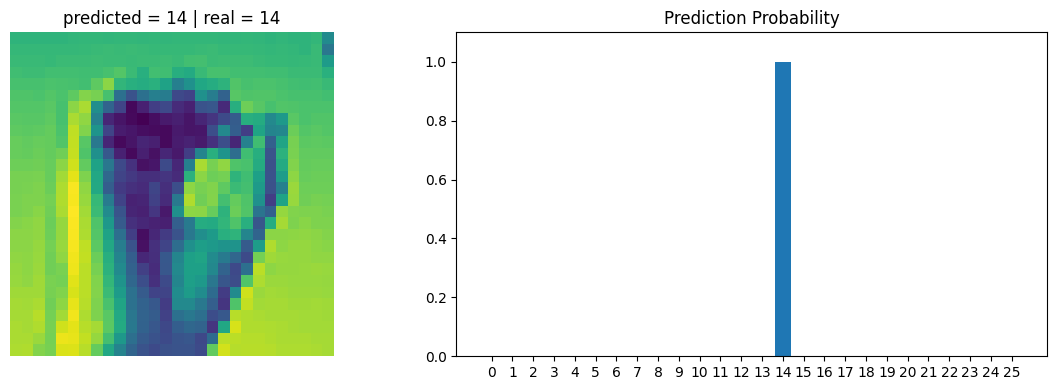

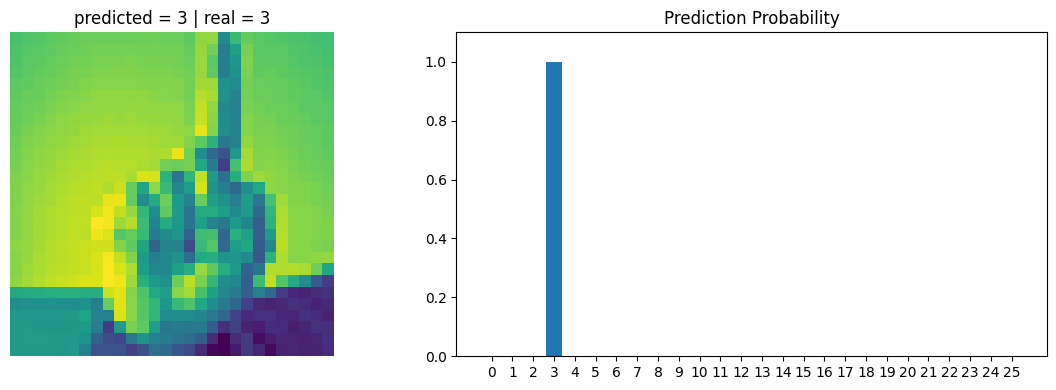

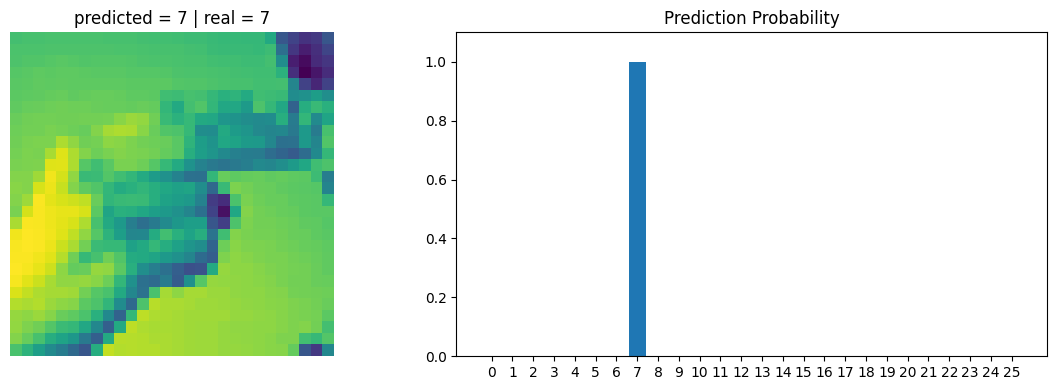

In [82]:
visualise_performance(model)

In [ ]:
model = CNNDropout().to(DEVICE)
train_network(model, train_dataloader, test_dataloader, 15, "cnndropout")

Epoch = 1: 100%|██████████| 215/215 [01:01<00:00,  3.50it/s, Loss =  1.871]


Test loss =  1.765 | Test cccuracy =  42.63


Epoch = 2: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  1.379]


Test loss =  1.322 | Test cccuracy =  57.35


Epoch = 3: 100%|██████████| 215/215 [01:01<00:00,  3.49it/s, Loss =  0.934]


Test loss =  0.869 | Test cccuracy =  70.13


Epoch = 4: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.773]


Test loss =  0.664 | Test cccuracy =  77.67


Epoch = 5:  24%|██▍       | 52/215 [00:14<00:40,  4.06it/s, Loss =  0.659]